# Modeling

Name: Robb Alexander and Ryan Bailis<br>
Class: CSCI349<br>
Semester: 2021SP<br>
Instructor: Brian King<br>

## Summary

We tried a plethora of classifiers, and as text classification was one of the topics we didn't go over class, it gave us a chance to struggle with the whole process and overcome it. A large challenge that we faced during our process was the gridsearch for the CNN, where we ported everything over to our communal PC, which has more processing power than our laptops. This was an issue because of the implementation of the packages and issues with `n_jobs`/multiprocessing. We looked through a few research papers to even try to solve the issue with the data in the first place and find a way to adjust how the counting/vectorizing of the text itself could increase performance.

Our choice to use nltk, and the power of nlp did increase the performace without much side effects, so we continued to use that model for all the classification. Every tweet is cleaned and also lemmantized. We learned the use of the Pipeline which is a great tool in sklearn, we used an ensemble method just to have some variety, we changed our initial `MultinomialNB` to `ComplementNB` after reading a research paper, and we upgraded tensorflow to have access to newer methods such as the powerful `TextVectorization` for the CNN.

In the end, we found a similar result as the researcher on his paper. It is quite simple for almost all classifiers to see the difference between offensive and unoffensive, but with hatespeech being so complex and perfect data, we could only get so far. It took a while to realize that you do not need an accuracy or macro-f1 of 95% or above to be successful. What we have achieved, in its rudimentary state can already assist humans with the tasks of surveilling the web for hate, albeit it is not strong enough to be operating on its own. We also checked out how it would perform on the simpler dataset, which just combines hatespeech and offensive language.

After finishing this, we took a look at how the researchers did it, our heatmaps look pretty similar except for one area, which is the neither category. We hypothesize that this is from the extra parameters they passed into the classifier on top of the text, e.g. sentiment, vocab, and readability, lengths, @s, link counts, syllables. We think this would help the neither category as `sentiment` is helpful to differentiate the positive meaning phrases.


In [1]:
import re
import os
import string
from IPython.core.display import display

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.wrappers.scikit_learn import KerasClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, cross_val_score

Using TensorFlow backend.


## Read in data and clean text and remove stop words and lemmantize.

In [2]:
def remove_punctuation(tweet):
    return tweet.translate(str.maketrans('', '', string.punctuation))

def remove_link(tweet):
    return re.sub(r'http\S+', '', tweet)

def remove_at(tweet):
    return re.sub(r'@\S+', '', tweet)

def remove_symbols_emoji(tweet):
    return re.sub(r'&.+?;', '', tweet)

def remove_retweet(tweet):
    return re.sub(r'RT', '', tweet)

In [3]:
df = pd.read_csv("data/labeled_data.csv", index_col=0)
df = df[["class", "tweet"]]

df["tweet"] = df["tweet"].apply(remove_link)
df["tweet"] = df["tweet"].apply(remove_at)
df["tweet"] = df["tweet"].apply(remove_symbols_emoji)
df["tweet"] = df["tweet"].apply(remove_retweet)
df["tweet"] = df["tweet"].apply(remove_punctuation)
df["tweet"] = df["tweet"].apply(str.lower)


df["tweet"] = df["tweet"].apply(nltk.word_tokenize)
sw = stopwords.words('english')
sw = set(map(remove_punctuation, sw))
wnl = WordNetLemmatizer()
bad_lemmas = set(['as', 'ass', 'was'])
df["tweet"] = df["tweet"].map(lambda x: [wnl.lemmatize(i) if i not in bad_lemmas else i for i in x])
df["tweet"] = df["tweet"].map(lambda x: [i for i in x if i not in sw])
df["tweet"] = df["tweet"].map(lambda x: ' '.join(x))


class_map = { 0 : "Hate Speech",
              1 : "Offensive Language",
              2 : "Neither" }

class_map_simple = { 0 : "Unoffensive",
                     1 : "Offensive"}

df_simple = df.copy()
df_simple["class"].replace({0: 1, 2: 0}, inplace=True)
df_simple["class"] = pd.Categorical(df_simple["class"])
df_simple["class"].cat.rename_categories(class_map_simple, inplace=True)

df["class"] = pd.Categorical(df["class"])
df["class"].cat.rename_categories(class_map, inplace=True)

In [4]:
tweet = df["tweet"].values
y = df["class"].values

## ComplementNB

In [8]:
tweet_train, tweet_test, y_train, y_test = train_test_split(df["tweet"], df["class"], test_size=0.25)

vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', stop_words='english', max_features=20000)
vect_train = vect.fit_transform(df["tweet"])

clf = ComplementNB()
y_pred = cross_val_predict(clf, vect_train, y, cv=10)
print(classification_report(y, y_pred, digits=3))

                    precision    recall  f1-score   support

       Hate Speech      0.214     0.212     0.213      1430
           Neither      0.717     0.711     0.714      4163
Offensive Language      0.898     0.901     0.900     19190

          accuracy                          0.829     24783
         macro avg      0.610     0.608     0.609     24783
      weighted avg      0.829     0.829     0.829     24783



## SGDClassifier

In [9]:
pipe = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier()),
              ])

y_pred = cross_val_predict(pipe, tweet, y, cv = 10)
print(classification_report(y, y_pred, digits=3))

                    precision    recall  f1-score   support

       Hate Speech      0.530     0.137     0.218      1430
           Neither      0.814     0.890     0.851      4163
Offensive Language      0.925     0.957     0.941     19190

          accuracy                          0.899     24783
         macro avg      0.756     0.662     0.670     24783
      weighted avg      0.884     0.899     0.884     24783



## ExtraTreesClassifier (ensemble)

In [10]:
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.fit_transform(y_test)

vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', stop_words='english', max_features=20000)
vect.fit(tweet_train)
vect_train = vect.transform(tweet_train)
vect_test = vect.transform(tweet_test)

clf = ExtraTreesClassifier(n_estimators=300)
clf.fit(vect_train, y_train_enc)

y_pred_ens = clf.predict(vect_test)

In [11]:
y_pred_ensrep = pd.Series(y_pred_ens)
y_pred_ensrep = y_pred_ensrep.replace({1:2,2:1})

print(classification_report(y_test, y_pred_ensrep.replace(class_map), digits=3))

                    precision    recall  f1-score   support

       Hate Speech      0.464     0.149     0.225       343
           Neither      0.835     0.855     0.845      1015
Offensive Language      0.921     0.960     0.940      4838

          accuracy                          0.898      6196
         macro avg      0.740     0.655     0.670      6196
      weighted avg      0.881     0.898     0.885      6196



### SGD GridSearch

In [12]:
param_grid = {
  'clf__loss' : ["hinge","modified_huber"],
  'clf__alpha' : [round(i, 5) for i in np.linspace(0.00005,0.0005, 10)],
}

grid = GridSearchCV(pipe, param_grid, return_train_score=True, cv=10, scoring=["accuracy","f1_macro"], refit="f1_macro", n_jobs=8, verbose=10)

grid_result = grid.fit(tweet, y)

df_grid_results = pd.DataFrame(grid_result.cv_results_)
df_grid_results = df_grid_results.sort_values(by="mean_test_f1_macro", ascending=False)[:5][["params", "mean_train_accuracy","mean_test_accuracy"]]

for i, row in df_grid_results.iterrows():
    display(row['params'])
    display(row['mean_train_accuracy'])
    display(row['mean_test_accuracy'])
    display("-------")

Fitting 10 folds for each of 20 candidates, totalling 200 fits


{'clf__alpha': 0.0001, 'clf__loss': 'modified_huber'}

0.9605643737434942

0.8971889456584625

'-------'

{'clf__alpha': 5e-05, 'clf__loss': 'modified_huber'}

0.972898092651859

0.8929926312420621

'-------'

{'clf__alpha': 0.00015, 'clf__loss': 'modified_huber'}

0.9512075976010166

0.8972696721874562

'-------'

{'clf__alpha': 0.0002, 'clf__loss': 'modified_huber'}

0.9445498127080642

0.8972696884662481

'-------'

{'clf__alpha': 5e-05, 'clf__loss': 'hinge'}

0.9453657865216059

0.9000943844353912

'-------'

                    precision    recall  f1-score   support

       Hate Speech      0.529     0.239     0.329      1430
           Neither      0.833     0.854     0.843      4163
Offensive Language      0.923     0.956     0.939     19190

          accuracy                          0.897     24783
         macro avg      0.762     0.683     0.704     24783
      weighted avg      0.885     0.897     0.888     24783



<AxesSubplot:>

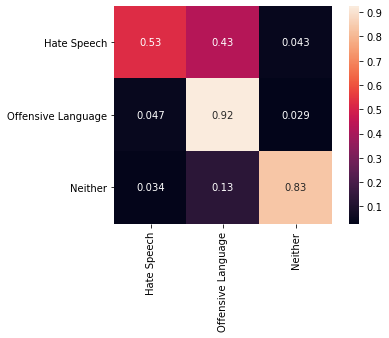

In [14]:
pipe = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(loss="modified_huber", alpha=0.0001)),
              ])

y_pred = cross_val_predict(pipe, tweet, y, cv = 10)
print(classification_report(y, y_pred, digits=3))
sns.heatmap(confusion_matrix(y, y_pred, normalize="pred", labels=list(class_map.values())).T, square = True, annot=True, yticklabels=list(class_map.values()), xticklabels=list(class_map.values()))

## Custom prediction

In [15]:
# !!!! 
string = ["i love my mom"]
pipe.fit(tweet, y)
pipe.predict(string)[0]

'Offensive Language'

## Convolutional neural network with semantic embedding

### Data vectorize

In [23]:
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(tweet).batch(128)
vectorizer.adapt(text_ds)

### Use gl0ve file to improve word relations (apriori) ~1gb

In [ ]:
%%time
embeddings_index = {}

with open(os.path.join(os.getcwd(), 'glove.twitter.27B.100d.txt'), encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

### Build matrix manually 

In [25]:
voc = vectorizer.get_vocabulary()
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0
word_index = dict(zip(voc, range(len(voc))))

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Build model (standard CNN text classification structure)

In [26]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False,
)

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(3, activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         2000200   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)        

### Vectorize input data and train

In [28]:
x_train = vectorizer(np.array([[s] for s in tweet_train])).numpy()
x_test = vectorizer(np.array([[s] for s in tweet_test])).numpy()

y_train = np.array(y_train)
y_test = np.array(y_test)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
146/146 [==============================] - 11s 73ms/step - loss: 0.4098 - acc: 0.8584 - val_loss: 0.3074 - val_acc: 0.9012
Epoch 2/20
146/146 [==============================] - 10s 72ms/step - loss: 0.2808 - acc: 0.9023 - val_loss: 0.2897 - val_acc: 0.8990
Epoch 3/20
146/146 [==============================] - 11s 72ms/step - loss: 0.2275 - acc: 0.9188 - val_loss: 0.2832 - val_acc: 0.8943
Epoch 4/20
146/146 [==============================] - 10s 72ms/step - loss: 0.1830 - acc: 0.9351 - val_loss: 0.2995 - val_acc: 0.8911
Epoch 5/20
146/146 [==============================] - 10s 72ms/step - loss: 0.1460 - acc: 0.9471 - val_loss: 0.3420 - val_acc: 0.8920
Epoch 6/20
146/146 [==============================] - 10s 72ms/step - loss: 0.1148 - acc: 0.9586 - val_loss: 0.3677 - val_acc: 0.8762
Epoch 7/20
146/146 [==============================] - 10s 72ms/step - loss: 0.0868 - acc: 0.9698 - val_loss: 0.4420 - val_acc: 0.8823
Epoch 8/20
146/146 [==============================] - 10s 72ms

### Model fit history plot

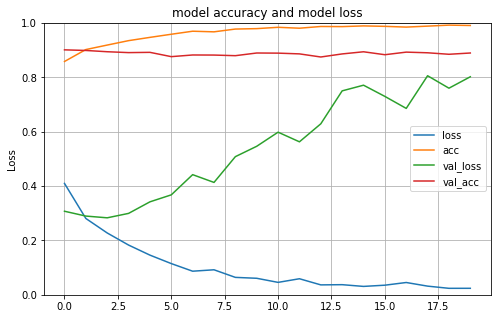

In [267]:
pd.DataFrame(history.history).plot(
 figsize=(8, 5),grid=True,
 ylim=(0,1), ylabel="Loss")
plt.title('model accuracy and model loss')
plt.show()

### Custom input

In [259]:
string_input = keras.Input(shape=(1,), dtype="string")
preds = model(vectorizer(string_input))
custominput_model = keras.Model(string_input, preds)

#### The semantic embedding made a huge improvement in determining deeper meanings of the `Neither` category

In [266]:
probabilities = custominput_model.predict(
    [["i love my mom"]]
)

print(probabilities[0])
class_map[np.argmax(probabilities[0])]

[0.0105102  0.07716451 0.9123253 ]


'Neither'

## CNN GridSearch
This is needed because we used a windows PC for more power. Non-unix machines output functional models as probabilities, so `predict` needs to be altered to call `argmax`

In [53]:
# https://scikit-learn.org/stable/developers/develop.html#specific-models
class KerasClassifierFunc(KerasClassifier):
    
    def decision_function(self, X):
        return self.model.predict(X)
    
    def predict(self, X, **kwargs):
        D = self.decision_function(X)
        return np.argmax(D, axis=1)

In [33]:
def create_keras_model(num_filters, kernel_size, ls, op):
    int_sequences_input = keras.Input(shape=(None,), dtype="int64")
    embedded_sequences = embedding_layer(int_sequences_input)
    x = layers.Conv1D(num_filters, kernel_size, activation="relu")(embedded_sequences)
    x = layers.MaxPooling1D(5)(x)
    x = layers.Conv1D(num_filters, 5, activation="relu")(x)
    x = layers.MaxPooling1D(5)(x)
    x = layers.Conv1D(num_filters, 5, activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(num_filters, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    preds = layers.Dense(3, activation="softmax")(x)
    model = keras.Model(int_sequences_input, preds)
    model.compile(
        loss=ls, optimizer=op, metrics=["acc"]
    )
    return model

In [34]:
clf = KerasClassifierFunc(build_fn=create_keras_model,  verbose=0)

param_grid = { 'num_filters' : [32, 64, 128],
               'kernel_size' : [3, 5, 7],
               'ls' : ['sparse_categorical_crossentropy'],
               'op' : ['rmsprop','SGD'],
               'epochs':[10, 15, 20],
               'batch_size' : [128,256]
             } 

In [35]:
grid = GridSearchCV(clf, param_grid, return_train_score=True, cv=5, scoring=["accuracy","f1_macro"], refit="f1_macro", n_jobs=-1, verbose=10)#https://stackoverflow.com/a/53012016

tweet_vect = vectorizer(np.array([[s] for s in tweet])).numpy()

grid_result = grid.fit(tweet_vect, y)
#56868sec 15.8hr

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5; 1/108] START batch_size=128, epochs=10, kernel_size=3, ls=sparse_categorical_crossentropy, num_filters=32, op=rmsprop
[CV 1/5; 1/108] END batch_size=128, epochs=10, kernel_size=3, ls=sparse_categorical_crossentropy, num_filters=32, op=rmsprop; accuracy: (train=0.936, test=0.869) f1_macro: (train=0.641, test=0.583) total time=  35.9s
[CV 2/5; 1/108] START batch_size=128, epochs=10, kernel_size=3, ls=sparse_categorical_crossentropy, num_filters=32, op=rmsprop
[CV 2/5; 1/108] END batch_size=128, epochs=10, kernel_size=3, ls=sparse_categorical_crossentropy, num_filters=32, op=rmsprop; accuracy: (train=0.932, test=0.857) f1_macro: (train=0.650, test=0.585) total time=  35.3s
[CV 3/5; 1/108] START batch_size=128, epochs=10, kernel_size=3, ls=sparse_categorical_crossentropy, num_filters=32, op=rmsprop
[CV 3/5; 1/108] END batch_size=128, epochs=10, kernel_size=3, ls=sparse_categorical_crossentropy, num_filters=32, op=rmspr

In [36]:
df_grid_results = pd.DataFrame(grid_result.cv_results_)
display(df_grid_results.sort_values(by="mean_test_f1_macro", ascending=False)[:15])
df_grid_results = df_grid_results.sort_values(by="mean_test_f1_macro", ascending=False)[:15][["params", "mean_train_accuracy","mean_test_accuracy"]]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_kernel_size,param_ls,param_num_filters,param_op,...,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_train_f1_macro,split1_train_f1_macro,split2_train_f1_macro,split3_train_f1_macro,split4_train_f1_macro,mean_train_f1_macro,std_train_f1_macro
4,89.690910,1.275670,1.129085,0.010243,128,10,3,sparse_categorical_crossentropy,128,rmsprop,...,0.713084,0.011421,1,0.943908,0.941253,0.938732,0.940316,0.923059,0.937453,0.007391
58,93.357626,1.813959,1.158190,0.012849,256,10,3,sparse_categorical_crossentropy,128,rmsprop,...,0.704164,0.019447,2,0.885603,0.901479,0.823996,0.904193,0.911246,0.885303,0.031781
94,163.694502,2.527738,1.144861,0.014043,256,20,3,sparse_categorical_crossentropy,128,rmsprop,...,0.698599,0.010636,3,0.965663,0.969092,0.953449,0.973991,0.976414,0.967722,0.008058
24,65.631926,0.597661,0.621349,0.006084,128,15,5,sparse_categorical_crossentropy,32,rmsprop,...,0.696840,0.014622,4,0.906191,0.920308,0.881207,0.887718,0.909386,0.900962,0.014410
56,57.827485,1.937565,0.830001,0.013190,256,10,3,sparse_categorical_crossentropy,64,rmsprop,...,0.695264,0.017797,5,0.784018,0.792492,0.854860,0.850730,0.844161,0.825252,0.030518
20,86.524544,2.179797,0.793132,0.011699,128,15,3,sparse_categorical_crossentropy,64,rmsprop,...,0.694995,0.011638,6,0.911298,0.935632,0.924270,0.924245,0.931054,0.925300,0.008223
2,57.378668,1.155671,0.779794,0.007067,128,10,3,sparse_categorical_crossentropy,64,rmsprop,...,0.694647,0.011332,7,0.748600,0.852113,0.886599,0.896055,0.879021,0.852478,0.053960
106,222.232246,1.001600,1.393234,0.015244,256,20,7,sparse_categorical_crossentropy,128,rmsprop,...,0.694259,0.013721,8,0.967967,0.985174,0.984125,0.985991,0.974505,0.979552,0.007123
86,108.062101,0.972055,0.915846,0.008123,256,15,7,sparse_categorical_crossentropy,64,rmsprop,...,0.694245,0.011815,9,0.957376,0.958906,0.952095,0.951988,0.952128,0.954498,0.003013
76,123.596562,2.509910,1.127169,0.016604,256,15,3,sparse_categorical_crossentropy,128,rmsprop,...,0.694078,0.031658,10,0.961217,0.861909,0.944398,0.950753,0.947797,0.933215,0.036094


### Final CNN

In [183]:
%%time

clf = KerasClassifierFunc(build_fn=create_keras_model, batch_size=128, epochs=10, kernel_size=3, ls="sparse_categorical_crossentropy", num_filters=128, op="rmsprop", verbose=0)
y_pred_final = cross_val_predict(clf, tweet_vect, y, cv=5)

Wall time: 7min 36s


                    precision    recall  f1-score   support

       Hate Speech      0.460     0.270     0.340      1430
           Neither      0.803     0.883     0.842      4163
Offensive Language      0.933     0.942     0.938     19190

          accuracy                          0.893     24783
         macro avg      0.732     0.698     0.707     24783
      weighted avg      0.884     0.893     0.887     24783



<AxesSubplot:>

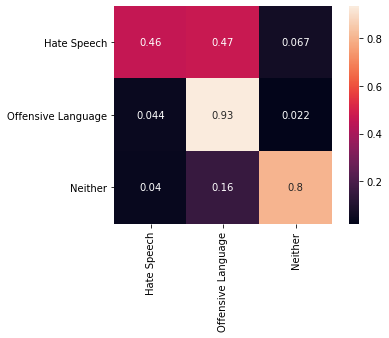

In [308]:
y_pred_finalrep = pd.Series(y_pred_final)
y_pred_finalrep = y_pred_finalrep.replace({1:2,2:1})

print(classification_report(y, y_pred_finalrep.replace(class_map), digits=3))
sns.heatmap(confusion_matrix(y,  y_pred_finalrep.replace(class_map), normalize="pred", labels=list(class_map.values())).T, square = True, annot=True, yticklabels=list(class_map.values()), xticklabels=list(class_map.values()))

We see that even now with all the tools its still hard to increase the hate-speech class prediction accuracy measures. This would require more work from the data end to get more balance and tweets. We have increased the macro-f1 to 70.7% which is slightly better than the previous few classifiers in the beginning. But if we take a look at the confusion matrix, it is a glaring step back compared to the SGD.

## Attempted Sampling


### Oversampling

In [456]:
vectorized_df = vect.transform(tweet)

smote = SMOTE(k_neighbors=3)
rand = RandomOverSampler()
X_to_sample, x_sample_test, Y_to_sample, y_sample_test = train_test_split(vectorized_df, y, test_size=0.5)

X_smote, y_smote = smote.fit_resample(X_to_sample, Y_to_sample)
X_rand, y_rand = rand.fit_resample(X_to_sample, Y_to_sample)

X_train, x_test, Y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2)
sgd1 = SGDClassifier()
sgd1.fit(X_train, Y_train)
pred_sgd = sgd1.predict(x_test)
print("SMOTE:")
print(classification_report(y_test, pred_sgd, digits=3))

X_train, x_test, Y_train, y_test = train_test_split(X_rand, y_rand, test_size=0.3)
sgd2 = SGDClassifier()
sgd2.fit(X_train, Y_train)
pred_sgd = sgd2.predict(x_test)
print("\nRANDOM OVER:")
print(classification_report(y_test, pred_sgd, digits=3))

SMOTE:
                    precision    recall  f1-score   support

       Hate Speech      0.893     0.975     0.932      1910
           Neither      0.904     0.988     0.944      1858
Offensive Language      0.977     0.806     0.883      1974

          accuracy                          0.921      5742
         macro avg      0.925     0.923     0.920      5742
      weighted avg      0.926     0.921     0.919      5742


RANDOM OVER:
                    precision    recall  f1-score   support

       Hate Speech      0.905     0.964     0.934      2883
           Neither      0.939     0.986     0.962      2854
Offensive Language      0.958     0.847     0.899      2876

          accuracy                          0.932      8613
         macro avg      0.934     0.933     0.932      8613
      weighted avg      0.934     0.932     0.932      8613



### Undersampling

In [457]:
rand = RandomUnderSampler()
X_rand, y_rand = rand.fit_resample(X_to_sample, Y_to_sample)
X_train, x_test, Y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3)
sgd3 = SGDClassifier()
sgd3.fit(X_train, Y_train)
pred_sgd = sgd3.predict(x_test)
print("RANDOM UNDER:")
print(classification_report(y_test, pred_sgd, digits=3))

RANDOM UNDER:
                    precision    recall  f1-score   support

       Hate Speech      0.886     0.965     0.924      2895
           Neither      0.920     0.989     0.954      2878
Offensive Language      0.966     0.805     0.878      2840

          accuracy                          0.920      8613
         macro avg      0.924     0.920     0.919      8613
      weighted avg      0.924     0.920     0.919      8613



### Sampling Predict

In [458]:
string = ["i love my mom"]
print(sgd1.predict(vect.transform(string))[0])
print(sgd2.predict(vect.transform(string))[0])
print(sgd3.predict(vect.transform(string))[0])

Neither
Neither
Neither


### Sampling Reality

<AxesSubplot:>

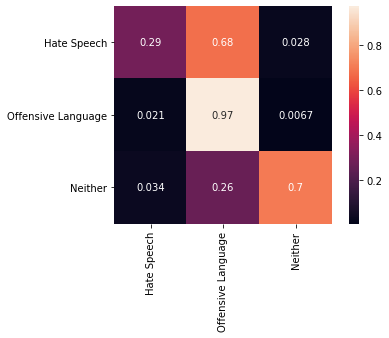

In [468]:
pred_sgd = sgd1.predict(x_sample_test)
sns.heatmap(confusion_matrix(y_sample_test,  pred_sgd, normalize="pred", labels=list(class_map.values())).T, square = True, annot=True, yticklabels=list(class_map.values()), xticklabels=list(class_map.values()))

Once we use a separate 50% of the original data for testing, we see that what is happening here is the sampling is struggling with saving the unique quality of hate speech words and thus making offensive language dominate everything. Even the neither category is losing a lot of important information. This is very misleading and shows that we cannot get any better than this unless we adjust the information that the original data has, such as semantics, tone, and context.

## Simple Version of data

              precision    recall  f1-score   support

   Offensive      0.971     0.971     0.971     20620
 Unoffensive      0.856     0.857     0.856      4163

    accuracy                          0.952     24783
   macro avg      0.913     0.914     0.914     24783
weighted avg      0.952     0.952     0.952     24783



<AxesSubplot:>

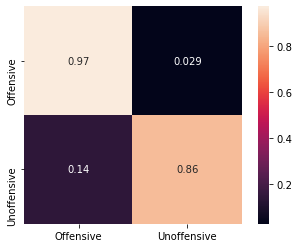

In [304]:
pipe = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(loss="modified_huber", alpha=0.0001)),
              ])

y_pred = cross_val_predict(pipe, df_simple["tweet"], df_simple["class"], cv = 10)

print(classification_report(df_simple["class"], y_pred, digits=3))
sns.heatmap(confusion_matrix(df_simple["class"], y_pred, normalize="pred").T, square = True, annot=True, yticklabels=list(class_map_simple.values())[::-1], xticklabels=list(class_map_simple.values())[::-1])

In the simple model we can see that It performs much better with accuracy and f1-score in the mid90s, even still having the with an imbalance of classes